# Import python libraries

and our own functions to load data, preprocessing steps, utilities and wrapper functions to calculate Green's functions, elastic love numbers from both FORTRAN code and estimated with neural network.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.nn.module import PyroParam, pyro_method
from src.data.data_loader import default_em, load_uplift
from src.data.preprocessing import (
    detrend,
    ffnn_input_vector,
    interval_outlier,
    load_thickness_time_series,
)
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import FFNN, compute_love_numbers, greens_function

print(PROJECT_ROOT)
pyro.set_rng_seed(42)


def compute_error(trues, predicted):
    """
    From course material
    """
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues) ** 2))
    return corr, mae, rae, rmse

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


Load uplift data from two GNET (Greenland GPS Network) stations and height data from Kangerlussuaq glacier estimated with ISSM. The time seriesfrom GNET and height data from ISSM are sampled weekly. The height data is further preprocessed with an interval outlier removal method to remove unrealistic peaks.

In [2]:
df_em = default_em()

df = load_uplift(timefreq="W")
df = df.set_index("Time")
df_tmp = df.copy()
# df_tmp = df_tmp.set_index("Time")
df.Thickness = (
    interval_outlier(df_tmp, M_step=24, max_std=2)
    .Thickness.interpolate()
    .fillna(method="bfill")
    .values
)

height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
df_em

/home/dnjllg/miniconda3/envs/MBML/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


df_em (DataFrame Earth Model) describes different earth parameters required for a FORTRAN program called e_clovers to compute elastic love numbers. We want to optimize only for the elastic contribution, which is the instantaneous response for the solid earth. The most interesting parameter to look at is rigidity. Rigidity is a parameter which describes how easily an elastic plate can be bend. A larger value corresponds to a stiffer plate. We only optimize for the first 60km of the lithosphere. 

The height data is compared to the uplift measured at the GNET station.



## Visualize the data

The time series are visualized to inspect the GNET and glacier height data.

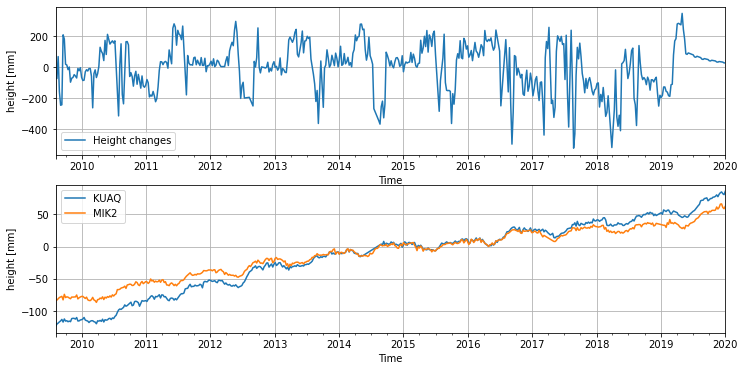

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
df.Thickness.plot(ax=ax[0])
ax[0].set_ylabel("height [mm]")
ax[0].legend(["Height changes"])
ax[0].grid()

df.Up_kuaq.plot(ax=ax[1])
df.Up_mik2.plot(ax=ax[1])
ax[1].set_ylabel("height [mm]")
ax[1].legend(["KUAQ", "MIK2"])
ax[1].grid()
plt.savefig("ch1_height_and_uplift.png", dpi=400)
plt.show()

We are interested in modeling the seasonal variations in the time series. The Green's function which is shown in report is a scaling factor on the height data. We can therefore Roughly estimate this parameter and show the similarities of the glacier height data and detrended GNET time series.



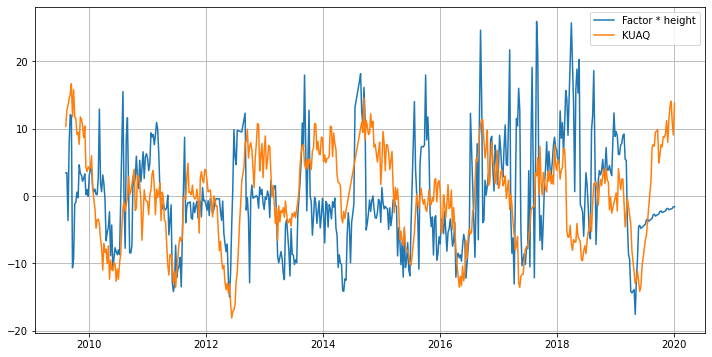

In [4]:
plt.figure(figsize=(12, 6))
# gf_test = -2e-4
tmp = height - np.mean(height)  # / np.std(height)
tmp2 = detrend(df.Up_kuaq.values)
tmp2 = tmp2 - np.mean(tmp2)  # / np.std(tmp2)
plt.plot(df.index, -0.05 * tmp, label="Factor * height")
plt.plot(df.index, tmp2, label="KUAQ")
plt.legend()
plt.grid()
plt.savefig("ch1_ts_compared.png", dpi=400)
plt.show()

By a quick inspection of the data from KUAQ GNET station and the glacier height data multiplied by a factor, seasonal patterns are clearly seen. The GNET station has an amplitide of 10-20mm a year!

The FORTRAN code to calculate the elastic love numbers and hence the Green's function is computational expensive. We want to find the least amount of spherical harmonics coefficients possible where the solution is stable.

In [5]:
gf_1 = []
gf_2 = []
append_1 = gf_1.append
append_2 = gf_2.append
llmax = [2**i for i in np.arange(7, 12)]
# [128, 256, 512, 1024, 2048]
for lmax in llmax:
    print(lmax)
    # lmax = 512
    lmin = 0
    lstep = 1
    CONF = {
        "EARTH_FILE": "earth_M3L70V01c.txt",
        "COMPRESS": "1",
        "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
        "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
    }
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)

    append_1(
        greens_function(
            hlove,
            nlove,
            [68.704665, -33.214577],
            [68.58700000, -33.05270000],
            arsurf=80e3 * 80e3,
        )
    )
    append_2(
        greens_function(
            hlove,
            nlove,
            [68.704665, -33.214577],
            [68.14029705, -31.45179999],
            arsurf=80e3 * 80e3,
        )
    )

128
256
512
1024
2048


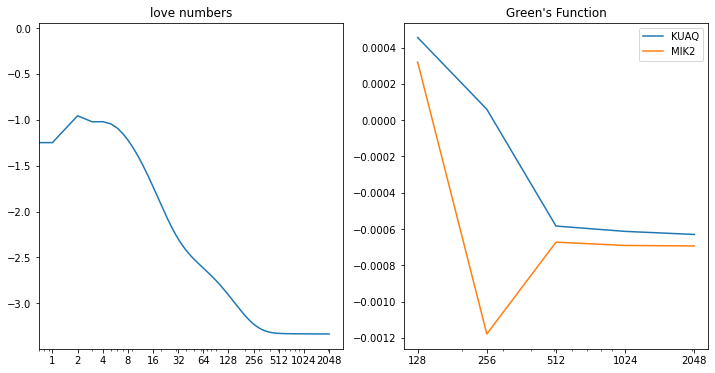

In [6]:
llmax2 = [2**i for i in np.arange(0, 12)]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].semilogx(hlove)
ax[0].set_xticks(ticks=llmax2)
ax[0].set_xticklabels(labels=llmax2)
ax[0].set_title("love numbers")

ax[1].semilogx(llmax, gf_1, label="KUAQ")
ax[1].semilogx(llmax, gf_2, label="MIK2")
ax[1].set_xticks(ticks=llmax)
ax[1].set_xticklabels(labels=llmax)
ax[1].set_title("Green's Function")
ax[1].legend()
plt.savefig("ch1_love_green_optimal", dpi=400)
plt.show()

From the plot above can it be seen that the elastic love numbers and the Green's function converge to a constant with at least 512 harmonic coefficients. The default Earth model have been used in this example. From the Green's function plot can it also be seen that the scaling factor for MIK2 is less than for KUAQ. This is a natural consequence of MIK2 GNET station is further away from the glacier.

In [7]:
# set the optimal configuration to estimate love numbers
lmax = 512
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

### Prepare data and split in train / test
The data prepared here does not only include the first model, but all later models as well. But what data is accessed depends on the chapter/model. This can be seen as how our work has progressed throughout project.

Both height and GNET stations are detrended and centered with a mean of zero.

Columns with one hot encoded month numbers are added to the height for later use in chapter 3 and 4.

In [8]:
df1 = pd.concat([df, df.index.month.to_series(index=df.index)], axis=1)
df1.columns = [*df1.columns[:-1], "Month"]
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [9]:
height = detrend(height)
standardized_height = height - np.mean(height)  # / np.std(height)
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X = torch.tensor(X_cat).float()

y1 = torch.tensor(detrend(up_kuaq)).float()
y1 = y1 - y1.mean()  # / y_train1.std()

y2 = torch.tensor(detrend(up_mik2)).float()
y2 = y2 - y2.mean()  # / y_train2.std()

y = torch.vstack([y1, y2]).T

A 80% train / 20% test set is used. The dataset in not permuted randomly for visualization purpose and because we need the temporal structure in chapter 5 for Generative Processes.

In [10]:
train_perc = 0.80  # percentage of training data
split_point = int(train_perc * len(y))
X_train = X[:split_point, :]
X_test = X[split_point:, :]
y_train = y[:split_point]
y_test = y[split_point:]

time_train = df.index[:split_point]
time_test = df.index[split_point:]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 435
num test: 109


# Chapter 1

### Define and train the model
In the first model we tried to add the FORTRAN to the model where the FORTRAN code is called by a bash script.

Only the GNET station KUAQ is included here.

We try to infer the rigidity of the two first layers in our earth model. This gave some unique problems with the e_clovers FORTRAN code and pyro. The compiled FORTRAN code is not stable for unrealistic Earth models and there is no stopping mechanism. This meant that the code would run for infinity if not manually stopped.

To overcome this problem was our first solution to code a IntervalFoldedDistribution that would be folded if it went below a certain threshold.

In [11]:
def model(X, obs=None, df_em=None):
    N = len(X)
    t = torch.linspace(0, 1, N)

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(1.2 * torch.ones(1)))

    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(
        dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1
    )
    rigidity_1 = 1e11 + 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)

    # rigidity layer 2
    loc, scale = 4, 0.5
    rigidity_dist_2 = IntervalFoldedDistribution(
        dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1
    )
    rigidity_2 = 1e11 + 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)

    # dictionary = {"sample": sample1}
    df_em["rigidity"][0] = rigidity_1.item()
    df_em["rigidity"][1] = rigidity_2.item()

    # Draw Love Numbers
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)

    # Draw Greens Function
    gf = pyro.deterministic(
        "gf",
        5e1
        * torch.tensor(
            greens_function(
                hlove,
                nlove,
                [68.704665, -33.214577],
                [68.58700000, -33.05270000],
                arsurf=80e3 * 80e3,
            )
        ),
    )

    # Draw target
    with pyro.plate("data"):
        w = pyro.sample(
            "w", dist.Normal(gf * X[:, 0], sigma_w), obs=obs
        )  # 1e5 is a scaling constant

    return w

In [12]:
pyro.set_rng_seed(42)
pyro.clear_param_store()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10, warmup_steps=2, num_chains=1)
mcmc.run(X_train, y_train[:, 0], df_em)

Sample: 100%|████| 12/12 [01:53,  9.47s/it, step size=8.99e-01, acc. prob=0.000]


In [13]:
# Show summary of inference results
mcmc.summary()  # exclude_deterministic=False


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  rigidity_1      1.30      0.00      1.30      1.30      1.30       nan       nan
  rigidity_2      2.66      0.00      2.66      2.66      2.66       nan       nan
    sigma[0]      7.51      0.00      7.51      7.51      7.51      0.53       nan

Number of divergences: 10


Note that a very small sample was calculated with MCMC NUTS. There are two reasons for this:
 - Code is very computational expensive to run. These 12 samples took around 2 minutes to complete. There were two bottlenecks, the FORTRAN code to compute love numbers and the estimation of the Green's function. We added a NUMBA decorator to the Green's function which made this part 500 times faster. Unfortunately was there fix to speed up the computation of love numbers.
 
 - The FORTRAN code to compute love numbers gets easily completely stuck for unrealistic earth models. Therefore at some point even if we wanted to run the Monte Carlo sampling it would not finish the run. Since the sampling have no knowledge about what earth parameters are realistic, this process extremely hard to control. This was still true even after our workaround with a folded distribution.
 
Below are two plots to show our prior distribution and the very limited posterior distribution. It would not make any sense to estimate the predicted results here, we therefore proceed to Chapter 2.

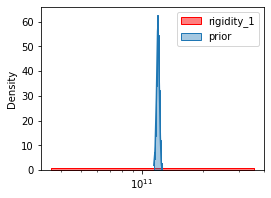

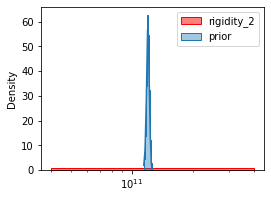

In [14]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]

rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4, 3))
    sns.histplot(
        1e11 + 1e10 * samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        log_scale=True,
    )
    plt.legend()
    plt.show()

# Chapter 2 FFNN

To estimate the love numbers faster and more realistic we trained a Feed Forward Neural Network. From our default Earth model it can be seen that both density, rigidity and bulk should increase with decreased radius to the core mantle boundary.

In [15]:
df_em = default_em()
df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


We add these restrictions for the training dataset for the FFNN. Therefore the rigidity layer 1 should not be greater than layer 2 and so forth. Further should the difference between two earth layers be somewhat similar i.e no unrealistic huge jumps. The rigidity layer is initialized with a uniform logspace. The rigidity of the second layer is there added a uniform distribution with a maximum of 4 times the logspace value. This insure no huge jumps are preferred.

In [16]:
N = 20000
rng = np.random.default_rng()
rigidity_columns = np.zeros((N, 2))
rigidity_1 = np.logspace(9, 10.25, N)
rng.shuffle(rigidity_1)
rigidity_columns[:, 0] = rigidity_1

for idx, rig in enumerate(rigidity_1):
    rigidity_columns[idx, 1] = rng.uniform(rig, rig * 4)

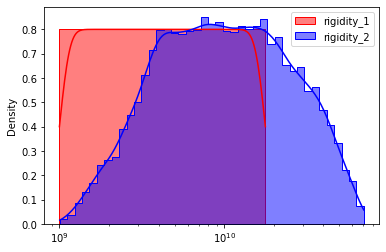

In [17]:
color = ["red", "blue"]
for i in range(2):
    sns.histplot(
        rigidity_columns[:, i],
        label=f"rigidity_{i+1}",
        kde=True,
        stat="density",
        element="step",
        color=color[i],
        log_scale=True,
    )
    plt.legend()
plt.savefig("ch2_FFNN_rigidity_training", dpi=400)

### load neural network to estimate love numbers

After the FFNN have been trained on 20000 different earth models, we load the model and the weights. The output of the FFNN are 513 elastic love numbers. In itself is it very time consuming to estimate 20000 earth models and train a FFNN. The benefit was that this should only be done once.

In [18]:
df_params, x = ffnn_input_vector(
    df_em, path="../data/processed/ffnn_variable_normalisation_params_512.csv"
)

ffnn = FFNN(31, 200, 513)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../models/ffnn_v2.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=513, bias=True)
  (relu): ReLU()
)

### Train model
We can now avoid using the folded distribution and choose a LogNormal distribution instead. To find the correct LogMean of the distribution we transform a log10 base to logNormal.

For this model and all later models the second GNET station, MIK2 been included.

In [19]:
logmean = np.log10(4e10) / np.log10(np.exp(1))

print(np.log10(3e10) / np.log10(np.exp(1)))
print(np.log10(4e10) / np.log10(np.exp(1)))

24.124463218608568
24.412145291060348


In [20]:
def model(X, x, df_params, obs=None, df_em=None):
    N = len(X)
    t = torch.linspace(0, 1, N)

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(1.2 * torch.ones(2)))

    rigidity_1 = pyro.sample("rigidity_1", dist.LogNormal(24.12 * torch.ones(1), 0.5))
    rigidity_2 = pyro.sample("rigidity_2", dist.LogNormal(24.41 * torch.ones(1), 0.5))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)

    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )
    gf = pyro.deterministic("gf", 5e1 * torch.tensor([gf_kuaq, gf_mik2]))

    # Draw target
    with pyro.plate("data", 2):
        w = pyro.sample(
            "w", dist.Normal(gf * X[:, 0][..., None], sigma_w), obs=obs
        )  # 1e5 is a scaling constant

    return w

In [21]:
pyro.set_rng_seed(42)
pyro.clear_param_store()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)

mcmc.run(X_train, x, df_params, y_train, df_em)

Sample: 100%|█| 1100/1100 [03:02,  6.02it/s, step size=6.12e-02, acc. prob=0.870


In [22]:
# Show summary of inference results
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
rigidity_1[0] 36696125440.00 19144366080.00 32929544192.00 11756157952.00 64294363136.00    969.83      1.00
rigidity_2[0] 43099299840.00 21146671104.00 39262871552.00 13331131392.00 72260116480.00   1110.54      1.00
     sigma[0]      6.67      0.22      6.66      6.36      7.09    394.16      1.00
     sigma[1]      5.41      0.18      5.41      5.11      5.69    352.87      1.00

Number of divergences: 0


In [23]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3  # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(
    1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6])
)
prem_rigidity = {
    "rigidity_1": prem_rigidity_1 * 1e8,
    "rigidity_2": prem_rigidity_2 * 1e8,
}

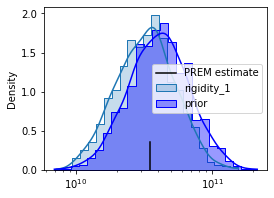

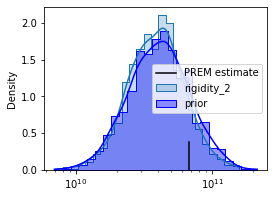

In [24]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]


# rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
# rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)
# rigidity_prior = 1e11 * pyro.sample("rigidity_prior", dist.Exponential(torch.ones(2000)))
rigidity_prior = pyro.sample(
    "rigidity_prior", dist.LogNormal(logmean * torch.ones(1000), 0.5)
)
for node in nodes:
    plt.figure(figsize=(4, 3))
    g = sns.histplot(
        # 1e11 + 1e10 * samples[node],
        samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        color="blue",
        log_scale=True,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend()
    plt.show()

## Compare to observations

In [25]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, x, df_params, None, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

w: (1000, 435, 2)
gf: (1000, 1, 2)


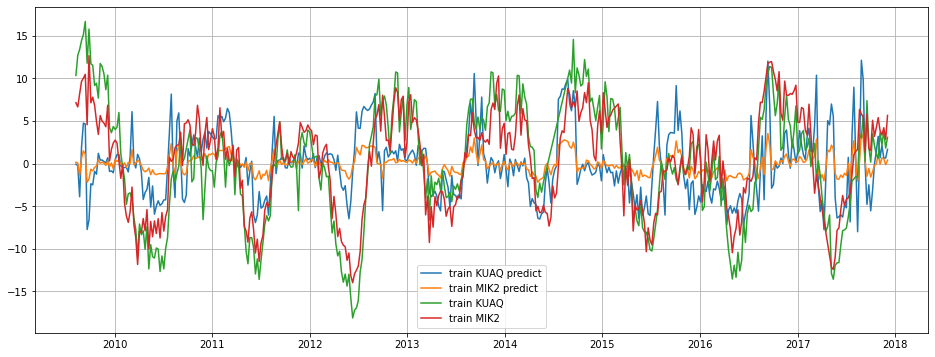

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(time_train, predictive["w"].mean(axis=0)[:, 0], label="train KUAQ predict")
plt.plot(time_train, predictive["w"].mean(axis=0)[:, 1], label="train MIK2 predict")
plt.plot(time_train, y_train[:, 0], label="train KUAQ")
plt.plot(time_train, y_train[:, 1], label="train MIK2")
plt.legend()
plt.grid()

In [27]:
y_hat = predictive["gf"].mean(axis=0) * X_test[:, 0].reshape(109, 1)

corr, mae, rae, rmse = compute_error(y_test.numpy(), y_hat.numpy())
print("CorrCoef: %.3f\nMAE: %.3f\nRAE: %.3f\nRMSE: %.3f" % (corr, mae, rae, rmse))

CorrCoef: 1.000
MAE: 5.929
RAE: 1.042
RMSE: 7.224


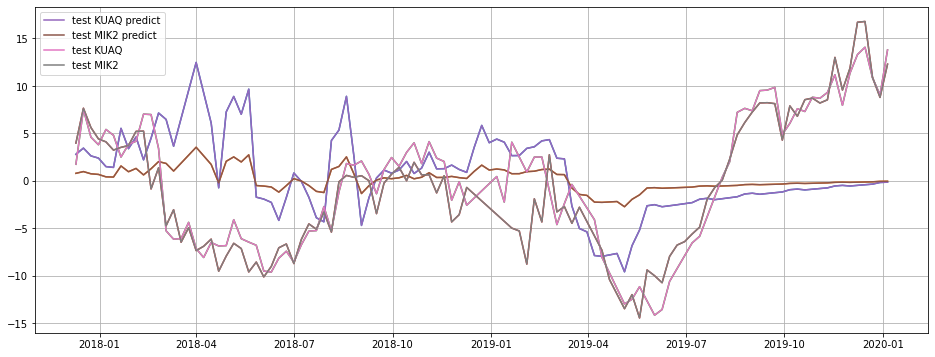

In [28]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, y_hat)
plt.plot(time_test, y_test)

plt.plot(time_test, y_hat[:, 0], label="test KUAQ predict")
plt.plot(time_test, y_hat[:, 1], label="test MIK2 predict")
plt.plot(time_test, y_test[:, 0], label="test KUAQ")
plt.plot(time_test, y_test[:, 1], label="test MIK2")
plt.legend()
plt.grid()

# Chapter 3 - added seasonality

Here is seasonality information included in the dataset. Some months tends to be noisier than others. Heteroscedastic regression is added for the variance because the events is occuring in a fixed interval of time. This allows for time-varying observation noise to be modeled.

### train the model

In [29]:
def model(X, x, df_params, obs=None, df_em=None):
    N = len(X)
    K = 2
    seasonality = 12  # months
    t = torch.linspace(0, 1, N)

    # seasonality modelling
    alpha_s = pyro.sample("alpha_s", dist.Normal(0.0, 1.0))
    sigma_s = pyro.sample(
        "sigma_s", dist.Normal(torch.zeros(seasonality, 2), torch.ones(seasonality, 2))
    )

    rigidity_1 = pyro.sample("rigidity_1", dist.LogNormal(24.12 * torch.ones(1), 0.5))
    rigidity_2 = pyro.sample("rigidity_2", dist.LogNormal(24.4 * torch.ones(1), 0.5))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)

    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )

    gf = pyro.deterministic("gf", 5e1 * torch.tensor([gf_kuaq, gf_mik2]))

    # Draw target
    with pyro.plate("data", K, dim=-1):
        w = pyro.sample(
            "w",
            dist.Normal(
                gf * X[:, 0][..., None], torch.exp(alpha_s + X[:, 1:].matmul(sigma_s))
            ),
            obs=obs,
        )
    return w

In [30]:
pyro.set_rng_seed(42)
pyro.clear_param_store()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
# mcmc.run(X_train, x, df_params, y_train, df_em)
mcmc.run(X_train, x, df_params, y_train, df_em)

Sample: 100%|█| 1100/1100 [03:38,  5.04it/s, step size=1.03e-01, acc. prob=0.901


In [31]:
# Show summary of inference results
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_s      1.72      0.22      1.70      1.35      2.05     38.12      1.00
rigidity_1[0] 36671528960.00 22157840384.00 30469898240.00 7863170048.00 65108848640.00    858.86      1.00
rigidity_2[0] 43685486592.00 22372503552.00 38350200832.00 12525899776.00 76947046400.00   1095.18      1.00
 sigma_s[0,0]     -0.23      0.25     -0.22     -0.64      0.15     47.39      1.00
 sigma_s[0,1]     -0.29      0.25     -0.28     -0.71      0.12     45.94      1.00
 sigma_s[1,0]     -0.06      0.25     -0.05     -0.48      0.35     47.16      1.00
 sigma_s[1,1]     -0.26      0.26     -0.24     -0.63      0.17     49.81      1.00
 sigma_s[2,0]      0.08      0.25      0.08     -0.29      0.48     48.65      1.00
 sigma_s[2,1]     -0.13      0.25     -0.12     -0.51      0.30     48.77      1.00
 sigma_s[3,0]      0.08      0.25      0.09     -0.33      0.48     48.33      1.00
 sigma_s[3,1]      0.02   

In [32]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3  # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_0 = np.mean(1 / 15 * (A[0] + C[0] - 2 * F[0] + 5 * N[0] + 6 * L[0]))
prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(
    1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6])
)
prem_rigidity = {
    "rigidity_0": prem_rigidity_0 * 1e8,
    "rigidity_1": prem_rigidity_1 * 1e8,
    "rigidity_2": prem_rigidity_2 * 1e8,
}

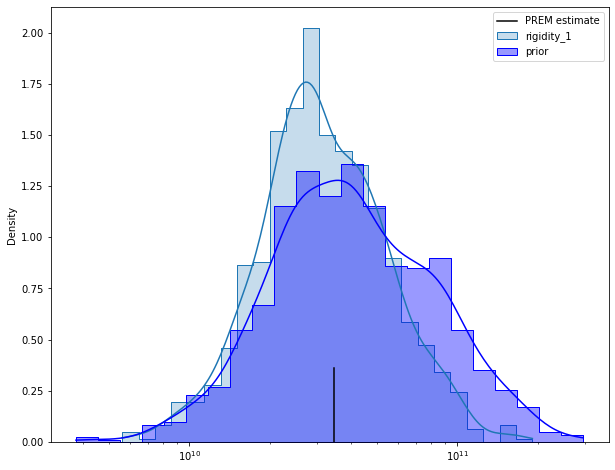

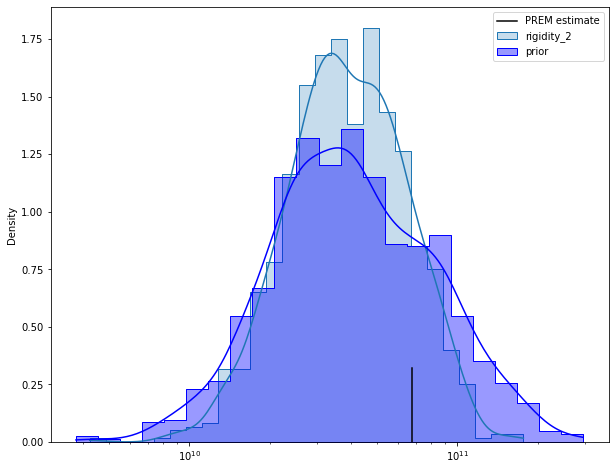

In [33]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]


# rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
# rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)
# rigidity_prior = 1e11 * pyro.sample("rigidity_prior", dist.Exponential(torch.ones(2000)))
rigidity_prior = pyro.sample(
    "rigidity_prior", dist.LogNormal(logmean * torch.ones(1000), 0.7)
)
for node in nodes:
    plt.figure(figsize=(10, 8))
    g = sns.histplot(
        # 1e11 + 1e10 * samples[node],
        samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        color="blue",
        log_scale=True,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend()
    plt.savefig("./ch3_{}_dist.png".format(node), dpi=400)
    plt.show()

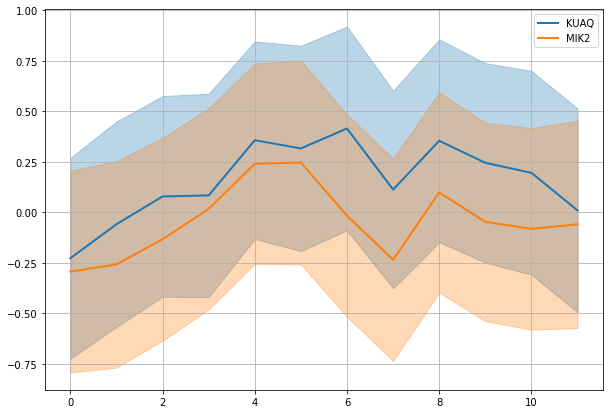

In [34]:
sigma_s_mu = samples["sigma_s"].mean(axis=0)
sigma_s_std = samples["sigma_s"].std(axis=0)

plt.figure(figsize=(10, 7))
plt.plot(sigma_s_mu[:, 0], lw=2, label="KUAQ")
plt.fill_between(
    range(12),  # plot the two-sigma uncertainty about the mean
    (sigma_s_mu[:, 0] - 2.0 * sigma_s_std[:, 0]).numpy(),
    (sigma_s_mu[:, 0] + 2.0 * sigma_s_std[:, 0]).numpy(),
    color="C0",
    alpha=0.3,
)
plt.plot(sigma_s_mu[:, 1], lw=2, label="MIK2")
plt.fill_between(
    range(12),  # plot the two-sigma uncertainty about the mean
    (sigma_s_mu[:, 1] - 2.0 * sigma_s_std[:, 1]).numpy(),
    (sigma_s_mu[:, 1] + 2.0 * sigma_s_std[:, 1]).numpy(),
    color="C1",
    alpha=0.3,
)
plt.legend()
plt.grid()
plt.savefig("./ch3_seasonality_sigma_s.png", dpi=400)

(2000,)


/home/dnjllg/miniconda3/envs/MBML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


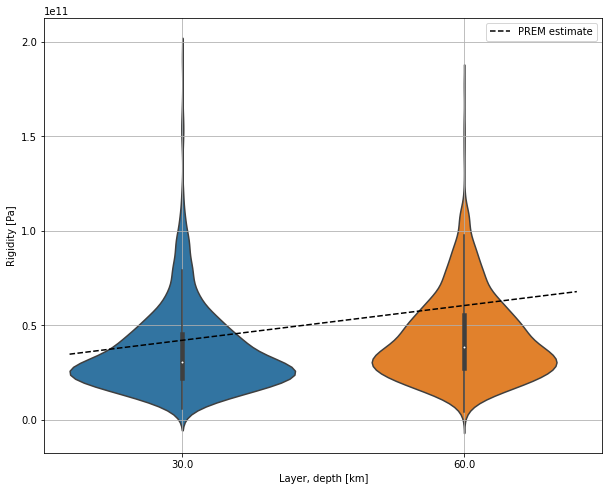

In [35]:
rigidity_list = []
prem_rigidity_list = [prem_rigidity["rigidity_0"]]
for node in nodes:
    rigidity_list.append(samples[node].numpy())
    prem_rigidity_list.append(prem_rigidity[node])

layers = np.hstack((30 * np.ones(1000), 60 * np.ones(1000)))
print(layers.shape)
df_layers = pd.DataFrame(
    np.array([np.vstack(rigidity_list).squeeze(), layers]).T,
    columns=["Rigidity [Pa]", "Layer, depth [km]"],
)

plt.figure(figsize=(10, 8))
sns.violinplot(x="Layer, depth [km]", y="Rigidity [Pa]", data=df_layers)
sns.lineplot(
    [-0.4, 1.4],
    prem_rigidity_list[1:],
    color="black",
    linestyle="--",
    label="PREM estimate",
)
plt.grid("minor")
plt.savefig("ch3_violin.png", dpi=400)

## Compared to observations

In [36]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, x, df_params, None, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

w: (1000, 435, 2)
gf: (1000, 1, 2)


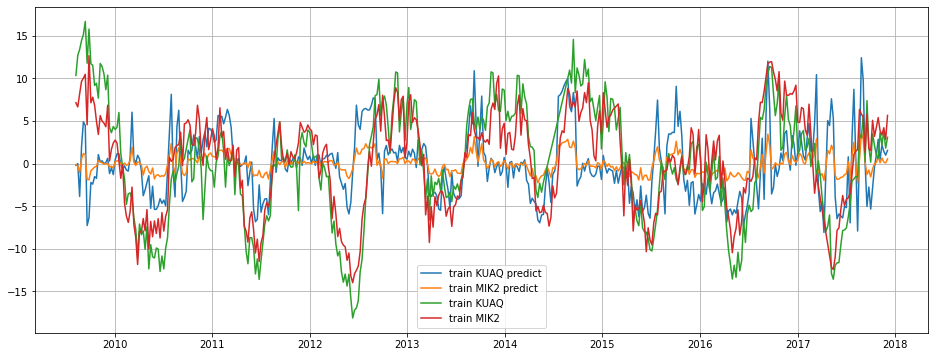

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(time_train, predictive["w"].mean(axis=0)[:, 0], label="train KUAQ predict")
plt.plot(time_train, predictive["w"].mean(axis=0)[:, 1], label="train MIK2 predict")
plt.plot(time_train, y_train[:, 0], label="train KUAQ")
plt.plot(time_train, y_train[:, 1], label="train MIK2")
plt.legend()
plt.grid()

In [38]:
y_hat = predictive["gf"].mean(axis=0) * X_test[:, 0].reshape(109, 1)

corr, mae, rae, rmse = compute_error(y_test.numpy(), y_hat.numpy())
print("CorrCoef: %.3f\nMAE: %.3f\nRAE: %.3f\nRMSE: %.3f" % (corr, mae, rae, rmse))

CorrCoef: 1.000
MAE: 5.929
RAE: 1.042
RMSE: 7.224


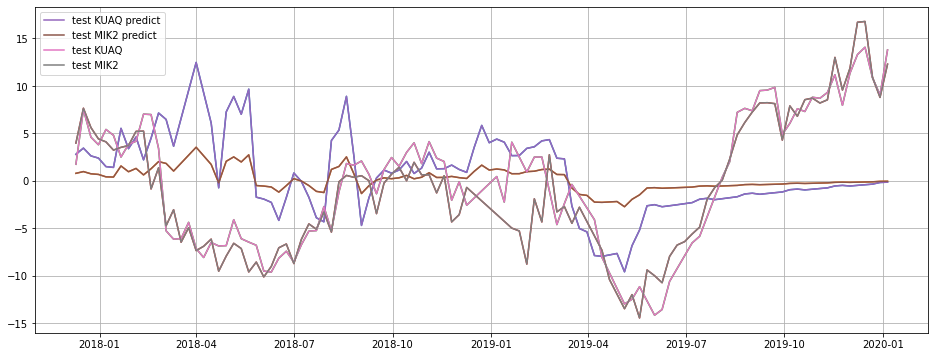

In [39]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, y_hat)
plt.plot(time_test, y_test)

plt.plot(time_test, y_hat[:, 0], label="test KUAQ predict")
plt.plot(time_test, y_hat[:, 1], label="test MIK2 predict")
plt.plot(time_test, y_test[:, 0], label="test KUAQ")
plt.plot(time_test, y_test[:, 1], label="test MIK2")
plt.legend()
plt.grid()

# Chapter 4 General 

## GP inference on thickness time series

In [41]:
y = -X_train[:, 0].double()
X = torch.linspace(0, 1, len(y)).double()
# y = (y - y.mean())/y.std()

# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1,
    variance=torch.tensor(30),
    lengthscale=torch.tensor(0.15),
    period=torch.tensor(0.1),
)
# gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.5))
Xu = torch.arange(100.0).double() / 100
gpr = gp.models.SparseGPRegression(
    X, y, kernel, Xu=Xu, noise=torch.tensor(20), jitter=1e-5
)

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.8))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 0.6))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 3000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

/home/dnjllg/miniconda3/envs/MBML/lib/python3.9/site-packages/pyro/contrib/gp/models/sgpr.py:137: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755888534/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  W = Kuf.triangular_solve(Luu, upper=False)[0].t()


corr = 0.5924386755440019, 
mae = 55.79017477724817, 
rae = 0.9177632471680623, 
rmse = 73.87390854555358
corr = 0.3177354948547583, 
mae = 110.1514652705655, 
rae = 0.9890805899713485, 
rmse = 143.1911643366511


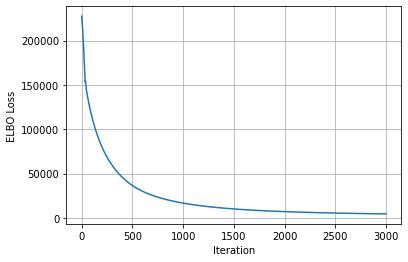

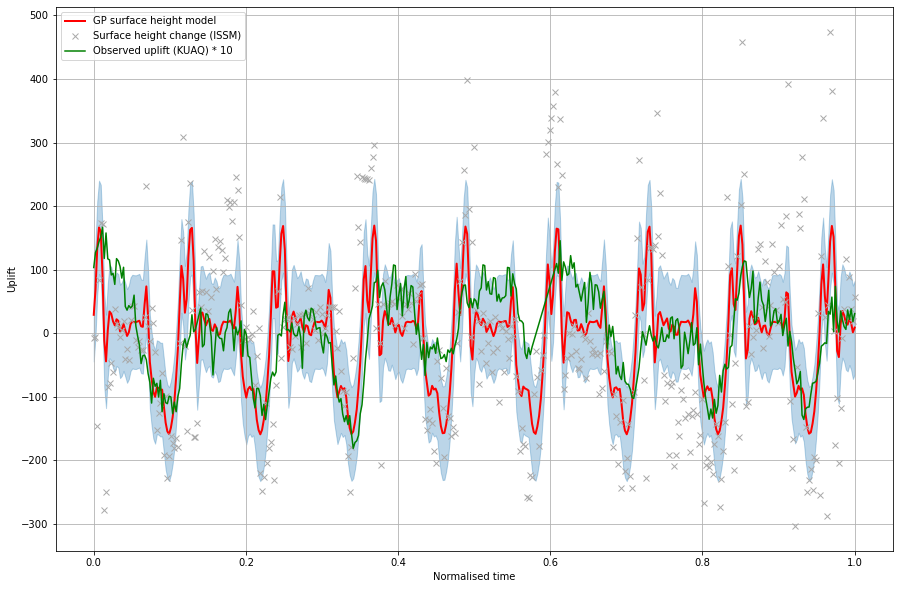

In [42]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("ELBO Loss")
plt.grid()
plt.savefig("./GP_loss.png", dpi=400)

plt.figure(figsize=(15, 10))
ax = plt.gca()
uplift = y_train[:, 0].numpy()
X_test = torch.linspace(0, 1, len(uplift)).double()  # test inputs
# plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[0, 1])
mean, cov = gpr(X_test, full_cov=True, noiseless=False)
sd = cov.diag().sqrt()  # standard deviation at each input point x

with torch.no_grad():
    ax.plot(
        X_test.numpy(), mean.numpy(), "r", lw=2, label="GP surface height model"
    )  # plot the mean
    ax.fill_between(
        X_test.numpy(),  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd).numpy(),
        (mean + 2.0 * sd).numpy(),
        color="C0",
        alpha=0.3,
    )

plt.plot(
    X_test,
    y,
    linestyle="None",
    marker="x",
    label="Surface height change (ISSM)",
    color="darkgrey",
)
plt.plot(X_test, 10 * uplift, label="Observed uplift (KUAQ) * 10", color="green")
plt.xlabel("Normalised time")
plt.ylabel("Uplift")
plt.grid()
plt.legend()
plt.savefig("./GP_spregression.png", dpi=400)

preds = gpr(X_test, full_cov=True)[0].detach()
corr, mae, rae, rmse = compute_error(preds.numpy(), uplift)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")
corr, mae, rae, rmse = compute_error(
    y.numpy(), uplift
)  # (upl - np.mean(upl)) / np.std(upl)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

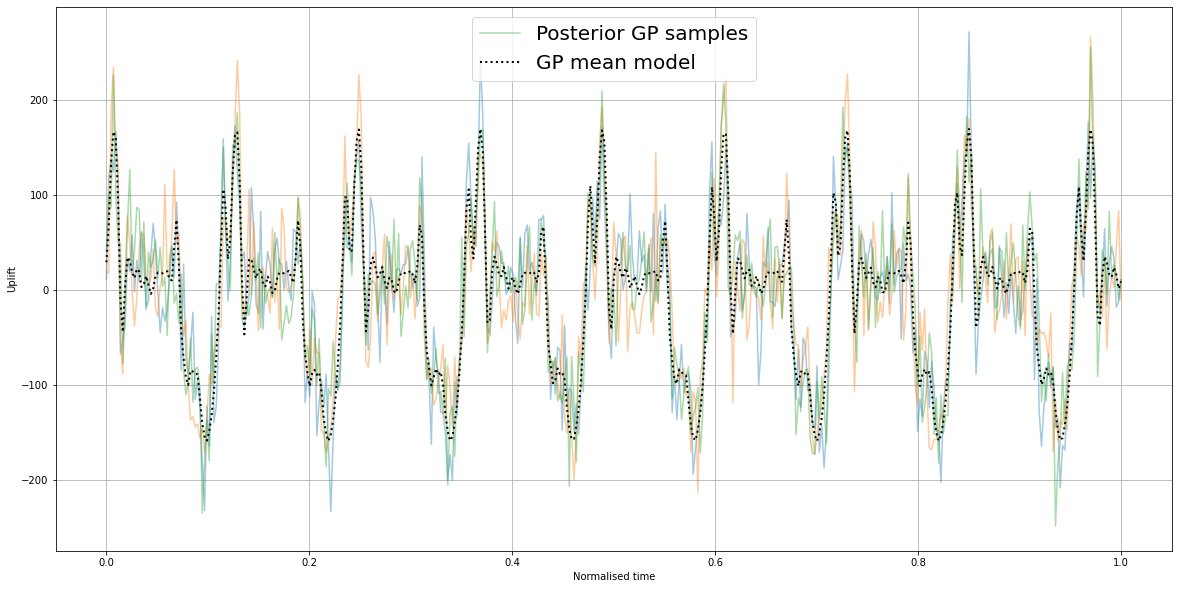

In [43]:
plt.figure(figsize=(20, 10))
mean, cov = gpr(X_test, full_cov=True, noiseless=False)
for i in range(2):
    with torch.no_grad():
        sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
        plt.plot(X_test, sample, alpha=0.4)

sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
plt.plot(X_test, sample.detach(), alpha=0.4, label="Posterior GP samples")
plt.plot(
    X_test, mean.detach(), "black", lw=2, linestyle=":", label="GP mean model", alpha=1
)
plt.xlabel("Normalised time")
plt.ylabel("Uplift")
plt.grid()
plt.legend(fontsize=20)
plt.savefig("./GP_posterior_samples.png", dpi=400)

In [49]:
mean, cov = gpr(X_test, full_cov=True, noiseless=False)

In [58]:
def model(X, x, df_params, mean_v=None, cov_v=None, obs=None, df_em=None):
    N = len(X)
    K = 2
    seasonality = 12  # months

    # seasonality modelling
    alpha_s = pyro.sample("alpha_s", dist.Normal(0.0, 1.0))
    sigma_s = pyro.sample(
        "sigma_s", dist.Normal(torch.zeros(seasonality, 2), torch.ones(seasonality, 2))
    )

    rigidity_1 = pyro.sample("rigidity_1", dist.LogNormal(24.12 * torch.ones(1), 0.5))
    rigidity_2 = pyro.sample("rigidity_2", dist.LogNormal(24.4 * torch.ones(1), 0.5))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)

    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )

    gf = pyro.deterministic("gf", 5e1 * torch.tensor([gf_kuaq, gf_mik2]))

    with pyro.plate("time", N):
        dh = pyro.sample("dh", dist.MultivariateNormal(mean_v.float(), cov_v.float()))

    # Draw target
    with pyro.plate("data", K):
        w = pyro.sample(
            "w",
            dist.Normal(
                gf * dh[..., None], torch.exp(alpha_s + X[:, 1:].matmul(sigma_s))
            ),
            obs=obs,
        )
    return w

In [59]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
# mcmc.run(X_train, x, df_params, y_train, df_em)
mcmc.run(X_train, x, df_params, mean_v=mean, cov_v=cov, obs=y_train, df_em=df_em)

Warmup:   5%|▌         | 56/1100 [09:45, 11.92s/it, step size=1.95e-03, acc. prob=0.815]

In [ ]:
# Show summary of inference results
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_s      1.80      0.19      1.79      1.52      2.13     25.61      1.00
rigidity_1[0] 33658433536.00 18787678208.00 29762191360.00 8094905856.00 57869262848.00   1091.39      1.00
rigidity_2[0] 44440014848.00 24018288640.00 39415189504.00 14246647808.00 80969023488.00   1181.11      1.00
 sigma_s[0,0]     -0.16      0.22     -0.17     -0.49      0.22     32.44      1.00
 sigma_s[0,1]     -0.27      0.21     -0.27     -0.59      0.10     34.27      1.00
 sigma_s[1,0]     -0.17      0.23     -0.17     -0.56      0.18     39.20      1.00
 sigma_s[1,1]     -0.33      0.22     -0.34     -0.72      0.00     34.89      1.00
 sigma_s[2,0]      0.20      0.22      0.21     -0.19      0.52     34.98      1.00
 sigma_s[2,1]     -0.17      0.22     -0.17     -0.53      0.19     34.57      1.01
 sigma_s[3,0]      0.27      0.22      0.28     -0.12      0.60     37.21      1.00
 sigma_s[3,1]      0.06   

In [ ]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3  # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_0 = np.mean(1 / 15 * (A[0] + C[0] - 2 * F[0] + 5 * N[0] + 6 * L[0]))
prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(
    1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6])
)
prem_rigidity = {
    "rigidity_0": prem_rigidity_0 * 1e8,
    "rigidity_1": prem_rigidity_1 * 1e8,
    "rigidity_2": prem_rigidity_2 * 1e8,
}

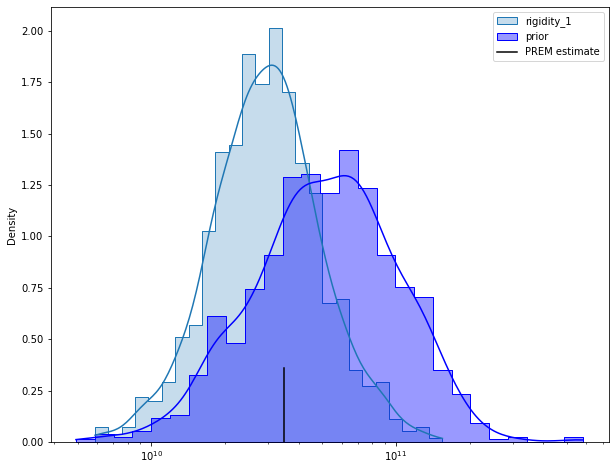

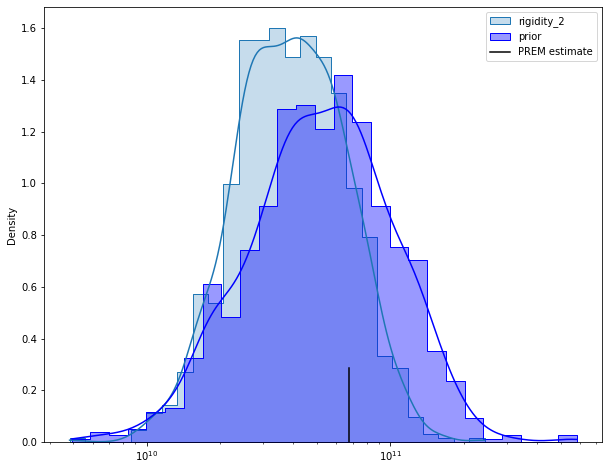

In [ ]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]


# rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
# rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)
# rigidity_prior = 1e11 * pyro.sample("rigidity_prior", dist.Exponential(torch.ones(2000)))
rigidity_prior = pyro.sample(
    "rigidity_prior", dist.LogNormal(logmean * torch.ones(1000), 0.7)
)
for node in nodes:
    plt.figure(figsize=(10, 8))
    g = sns.histplot(
        # 1e11 + 1e10 * samples[node],
        samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        color="blue",
        log_scale=True,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend()
    plt.savefig("./ch3_{}_dist.png".format(node), dpi=400)
    plt.show()
    

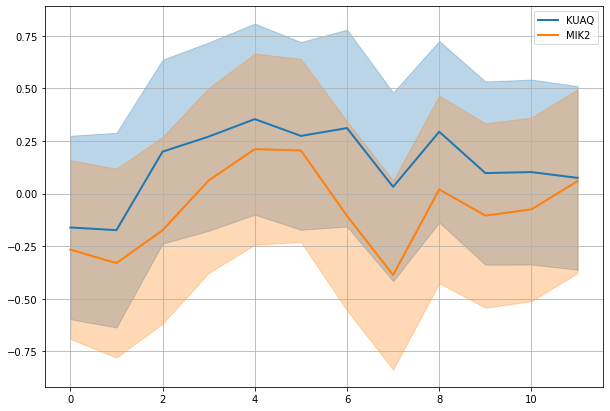

In [ ]:
sigma_s_mu = samples["sigma_s"].mean(axis=0)
sigma_s_std =samples["sigma_s"].std(axis=0)

plt.figure(figsize=(10,7))
plt.plot(sigma_s_mu[:, 0], lw=2, label="KUAQ")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 0] - 2.0 * sigma_s_std[:, 0]).numpy(),
            (sigma_s_mu[:, 0] + 2.0 * sigma_s_std[:, 0]).numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(sigma_s_mu[:, 1], lw=2, label="MIK2")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 1] - 2.0 * sigma_s_std[:, 1]).numpy(),
            (sigma_s_mu[:, 1] + 2.0 * sigma_s_std[:, 1]).numpy(),
            color="C1",
            alpha=0.3,
        )
plt.legend()
plt.grid()
plt.savefig("./ch3_seasonality_sigma_s.png", dpi=400)

(2000,)


/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


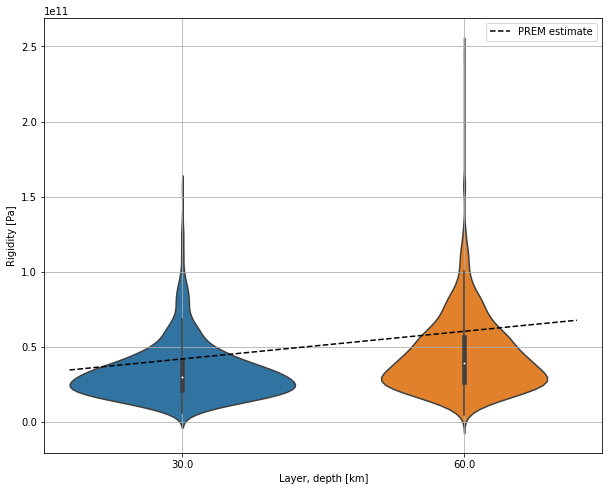

In [ ]:
rigidity_list = []
prem_rigidity_list = [prem_rigidity["rigidity_0"]]
for node in nodes:
    rigidity_list.append(samples[node].numpy())
    prem_rigidity_list.append(prem_rigidity[node])
    
layers = np.hstack((30 * np.ones(1000), 60 * np.ones(1000)))
print(layers.shape)
df_layers = pd.DataFrame(np.array([np.vstack(rigidity_list).squeeze(), layers]).T, 
                         columns=["Rigidity [Pa]", "Layer, depth [km]"])

plt.figure(figsize=(10,8))
sns.violinplot(x = "Layer, depth [km]", y = "Rigidity [Pa]", data = df_layers)
sns.lineplot([-0.4, 1.4], prem_rigidity_list[1:], color="black", linestyle="--", label="PREM estimate")
plt.grid('minor')
plt.savefig("ch3_violin.png", dpi=400)